# Thinkful - Final Capstone: Siting Wind Farms (continued)
## Supervised Learning models

### Jeremy Brezovan, December 2019


## Imports and functions

In [38]:
import time

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
from shapely.geometry import MultiLineString
from shapely.geometry import Polygon
from shapely.ops import nearest_points
from shapely.ops import unary_union

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix

%matplotlib inline

In [37]:
def show_feat_importance(model,df):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    df_cols = df.shape[1]
    
    for f in range(df_cols):
        print("%d. feature %d: %s (%f)" % (f + 1, indices[f],
                                           df.columns[f],
                                           importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(df_cols),
            importances[indices],
            color="r",
            yerr=std[indices],
            align="center")
    plt.xticks(range(df_cols), indices)
    plt.xlim([-1, df_cols])
    plt.show()

## Data: wrangled. Now, build something

In the first notebook for this capstone, I introduced the datasets, generated a target feature using an unsupervised learning model, and detailed the use of some external scripts that generated additional features that can be used to train a supervised learning model.

My original thought was to build two supervised learning models--one with a binary output, simply stating whether or not a cell from the NREL dataset would be a good site for a turbine. (A cell is approximately 1/3 of a square degree of latitude/longitude, or 23x23 miles / 37x37 km.)

The proposed second model would be trained on the attributes of land where turbines currently exist, and output the turbine_class, describing what kind of turbine would be best suited for an area.

What I found in exploring the unsupservised model's output was that the turbine_classes were largely determined by project age and size. Turbine technology has improved over time, leading to projects with fewer turbines, but turbines that are larger and have a higher output capacity.

In [55]:
disk_dir='/home/jeremy/Documents/Jupyter/Final Capstone/nrel_augmented_by_state/'
us_state = 'KS'

In [56]:
lower48_borders = gpd.read_file('./lower48_borders.geojson',driver='GeoJSON')

In [57]:
nrel_state = gpd.read_file('./nrel_augmented_by_state/nrel_augmented_{}.geojson'.format(us_state),driver='GeoJSON')

In [58]:
vc_le = LabelEncoder()
nrel_state['volt_class_encoded'] = vc_le.fit_transform(nrel_state['VOLT_CLASS'])

In [59]:
nrel_state['target'] = np.where( (nrel_state['turbine_count'] > 0) | (nrel_state['wind_class_excl'] >= 3), 1, 0)

In [60]:
# Train/test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(nrel_state[['SHAPE__Len','VOLTAGE','volt_class_encoded',
                                                                'dist_to_nearest_line','line_count',
                                                                'wind_class','geometry']],
                                                        nrel_state['target'], 
                                                        test_size=0.33, 
                                                        random_state=42)

## SGD Classifier / incremental learning

The SGD classifier performed well enough training against a single dataset...but the random forest below outperformed the SGD classifier.

I had a thought to try incremental learning--to generate a full set of data for every state, and train a model using all of those datasets. Unfortunately, generating 48 states' worth of data turned out to be a major challenge in terms of processing time, power, and disk space.

Had I the resources to proceed with that plan, I would replace .fit() below with .partial_fit(), and feed in states' training datasets one by one.

In [61]:
sgdc = SGDClassifier()
sgdc.fit(X_train1.drop('geometry',axis='columns'),y_train1)#,classes=[0,1])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [62]:
# How does it do against our test dataset?
y_pred1_sgd = sgdc.predict(X_test1.drop('geometry',axis='columns'))
sgdc.score(X_test1.drop('geometry',axis='columns'),y_test1)

0.09753404490246595

## Random Forest

The augmented NREL dataset doesn't have a lot of features, so I thought perhaps a random forest would be easy to train. As it turns out--yes! Over 90% without any tuning whatsoever.

In [63]:
# Train the model
rfc = RandomForestClassifier()
rfc.fit(X_train1.drop('geometry',axis='columns'),y_train1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [64]:
# How does it do against our test dataset?
y_pred1 = rfc.predict(X_test1.drop('geometry',axis='columns'))
rfc.score(X_test1.drop('geometry',axis='columns'),y_test1)

0.9389032020610968

In [65]:
confusion_matrix(y_test1,y_pred1)

array([[ 449,  346],
       [ 152, 7204]])

Feature ranking:
1. feature 3: SHAPE__Len (0.451512)
2. feature 5: VOLTAGE (0.250149)
3. feature 0: volt_class_encoded (0.150026)
4. feature 4: dist_to_nearest_line (0.133029)
5. feature 1: line_count (0.007779)
6. feature 2: wind_class (0.007505)


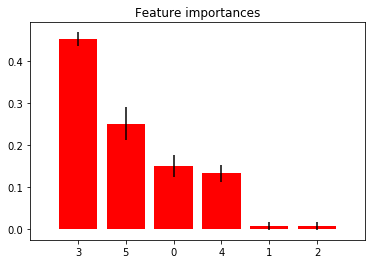

In [66]:
show_feat_importance(rfc,X_train1.drop('geometry',axis='columns'))

# It's interesting that the power line data is the most significant to the model.

In [67]:
X_test_out1 = X_test1.copy(deep=True)
X_test_out1 = gpd.GeoDataFrame(X_test_out1)
X_test_out1['build_here'] = y_pred1

In [68]:
X_test_out1.shape

(8151, 8)

In [69]:
X_test_out1['build_here'].value_counts()

1    7550
0     601
Name: build_here, dtype: int64

In [71]:
turbines_state = gpd.read_file('./turbines_by_state/turbines_{}.geojson'.format(us_state),driver='GeoJSON')

In [73]:
def turbine_color(turbine_class):
    if turbine_class == 0:
        return 'limegreen'
    elif turbine_class == 1:
        return 'gold'
    elif turbine_class == 2:
        return 'orangered'
    else:
# Blue dots on the map mean shenanigans occurred and we need to investigate
        return 'blue'

<Figure size 432x288 with 0 Axes>

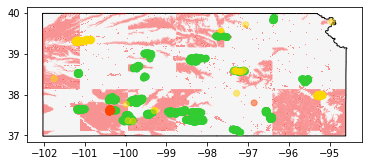

In [78]:
fig = plt.figure()
ax = lower48_borders.loc[lower48_borders['STUSPS'] == us_state].plot(color='whitesmoke',edgecolor='black')
X_test_out1.loc[X_test_out1['build_here'] == 1].plot(ax=ax,color='red',alpha=.4)
scatter = plt.scatter(turbines_state['xlong'],turbines_state['ylat'],
            color=turbines_state['turbine_class'].apply(lambda x: turbine_color(x)),
            alpha=.5)

## What differentiates good sites from other sites?

## Conclusions?

## Future work